In [ ]:
# Вебинар 6. Двухуровневые модели рекомендаций


In [ ]:
Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [2]:
data = pd.read_csv('../data/retail_train.csv')
item_features = pd.read_csv('../data/product.csv')
user_features = pd.read_csv('../data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\a.kraev\recommender_systems\Lesson_6\src\utils.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['price'] = data_train['sales_value'] / data_train['quantity']


Decreased # items from 83685 to 5000


In [4]:
recommender = MainRecommender(data_train_lvl_1)

In [5]:
recommender.get_als_recommendations(2375, N=5)

[899624, 1004906, 845208, 1037863, 883932]

In [6]:
recommender.get_own_recommendations(2375, N=5)

[1036501, 1085983, 1079023, 907099, 910439]

In [7]:
recommender.get_similar_items_recommendation(2375, N=5)

array([1081177, 1002558,  865178, 5996036,  860528], dtype=int64)

In [8]:
recommender.get_similar_users_recommendation(2375, N=5)

[1062572, 1116050, 10198378, 1073150, 1096261]

In [ ]:
### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [9]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [10]:
result_lvl_1['similar_users'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_users_recommendation(x, N=50))

In [10]:
#Пока пробуем отобрать 50 кандидатов (k=50)
result_lvl_1['own'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))
result_lvl_1['als'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=50))
result_lvl_1['similar_items'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=50))
result_lvl_1['similar_users'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_users_recommendation(x, N=50))

In [16]:
result_lvl_1.head(2)

,user_id,actual,own,als,similar_items,similar_users,als_50
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[856942, 9297615, 5577022, 9655212, 931136, 11...","[6533936, 1094924, 905436, 1082212, 819518, 55...","[999999, 923746, 961554, 1126899, 844179, 1070...","[999999, 864893, 969866, 1096573, 7152455, 102...","[6533936, 1094924, 905436, 1082212, 819518, 55..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[1076580, 911974, 831125, 5567582, 1070803, 82...","[880150, 907647, 866211, 977497, 5565784, 1075...","[1081177, 824758, 9526411, 7135183, 9297615, 5...","[856942, 1134296, 1114653, 1059236, 1043663, 1...","[880150, 907647, 866211, 977497, 5565784, 1075..."


In [12]:
recall_arr = list()
for col in result_lvl_1.iloc[:,2:]:
    print(col, end=': ')
    recall_arr.append(result_lvl_1.apply(lambda row: recall_at_k(row[col], row['actual'], k=50), axis=1).mean())
    print(recall_arr[-1])

own: 0.0903161834783844
als: 0.056167886052827916
similar_items: 0.015052130710248529
similar_users: 0.003750971958899407


In [17]:
recall_arr =[]
for k in [50, 100, 200, 250, 300, 500]:
    result_lvl_1[f'als_{k}'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=k))
    
    recall_arr.append(result_lvl_1.apply(lambda row: recall_at_k(row[f'als_{k}'], row['actual'], k=k), axis=1).mean())

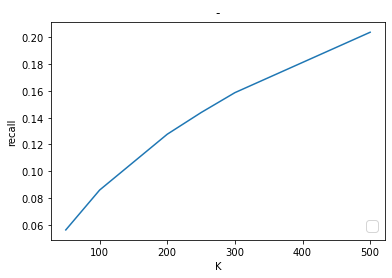

In [18]:
import matplotlib.pyplot as plt

plt.plot([50, 100, 200, 250, 300, 500], recall_arr)

plt.xlabel('K')
plt.ylabel('recall')
plt.title('-')
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

In [ ]:
### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [163]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))

users_lvl_2.head()

,user_id,candidates
0,2070,"[834103, 1105426, 1119399, 1085604, 917033, 93..."
1,2021,"[950935, 1119454, 1019142, 835578, 863762, 101..."
2,1753,"[13842224, 1089066, 862981, 901543, 879755, 96..."
3,2120,"[999999.0, 923746.0, 961554.0, 1126899.0, 8441..."
4,1346,"[5574377, 5569309, 903738, 5568758, 8090560, 8..."


In [164]:
df=pd.DataFrame({'user_id':users_lvl_2.user_id.values.repeat(len(users_lvl_2.candidates[0])),
                 'item_id':np.concatenate(users_lvl_2.candidates.values)})

In [165]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = df.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)

In [166]:
targets_lvl_2.head(10)

,user_id,item_id,target
0,2070,834103.0,1.0
1,2070,834103.0,1.0
2,2070,834103.0,1.0
3,2070,834103.0,1.0
4,2070,834103.0,1.0
5,2070,834103.0,1.0
6,2070,834103.0,1.0
7,2070,834103.0,1.0
8,2070,834103.0,1.0
9,2070,834103.0,1.0


In [167]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

In [168]:
average_check = data_train_lvl_2.groupby(['user_id', 'basket_id'], as_index=False)['sales_value'].sum()
average_check = average_check.groupby('user_id', as_index=False).mean()
average_check = average_check.drop('basket_id', axis=1)
average_check.rename(columns={'sales_value': 'average_check'}, inplace=True)
targets_lvl_2 = targets_lvl_2.merge(average_check, on='user_id', how='left')

In [169]:
num_pur = data_train_lvl_2.merge(item_features, on='item_id', how='left')
num_pur = num_pur.groupby(['user_id', 'department'], as_index=False)['quantity'].sum()
num_pur.rename(columns={'quantity': 'num_pur'}, inplace=True)
num_pur['num_pur'].fillna(0, inplace=True)
targets_lvl_2 = targets_lvl_2.merge(num_pur, on=['user_id', 'department'], how='left')

In [170]:
price = data.loc[:,('item_id', 'quantity', 'sales_value')]
price = price.groupby('item_id', as_index=False)[['quantity', 'sales_value']].sum()
price['price'] = price['sales_value'] / price['quantity']
price = price.drop(['quantity', 'sales_value'], axis=1)
targets_lvl_2 = targets_lvl_2.merge(price, on='item_id', how='left')

In [171]:
goods_per_week = data_train_lvl_2.groupby(['item_id', 'week_no'], as_index=False)['quantity'].sum()
goods_per_week = goods_per_week.groupby('item_id', as_index=False)['quantity'].mean()
goods_per_week.rename(columns={'quantity': 'goods_per_week'}, inplace=True)
goods_per_week['goods_per_week'].fillna(0, inplace=True)


targets_lvl_2 = targets_lvl_2.merge(goods_per_week, on='item_id', how='left')

In [172]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [173]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'average_check',
 'num_pur',
 'price',
 'goods_per_week']

In [174]:
X_train

,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,average_check,num_pur,price,goods_per_week
0,2070,834103.0,2224.0,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,213.0,1.092059,10.166667
1,2070,834103.0,2224.0,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,213.0,1.092059,10.166667
2,2070,834103.0,2224.0,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,213.0,1.092059,10.166667
3,2070,834103.0,2224.0,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,213.0,1.092059,10.166667
4,2070,834103.0,2224.0,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,213.0,1.092059,10.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114194,1745,1088147.0,69.0,GROCERY,Private,FRZN VEGETABLE/VEG DSH,FRZN BAGGED VEGETABLES - PLAIN,16 OZ,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown,13.970000,3.0,1.574127,9.000000
114195,1745,1085983.0,586.0,GROCERY,National,COOKIES/CONES,TRAY PACK/CHOC CHIP COOKIES,18 OZ,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown,13.970000,3.0,2.915598,1.666667
114196,1745,868745.0,69.0,GROCERY,Private,SALD DRSNG/SNDWCH SPRD,POURABLE SALAD DRESSINGS,16 OZ,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown,13.970000,3.0,1.157642,2.333333
114197,1745,995055.0,69.0,GROCERY,Private,CHEESE,IWS SINGLE CHEESE,10.66 OZ,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown,13.970000,3.0,1.136637,4.000000


In [175]:
lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats, )
lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [176]:
from lightgbm import LGBMRanker

lgb_params = { 
    'objective':'lambdarank',
    'boosting_type': 'gbdt',
    'n_estimators': 500,
    'learning_rate': 0.1,
    'max_depth': 4,
    'categorical_column': cat_feats,
    'random_state': 27,
    'verbose': 1,
    'is_unbalance': True
}

In [177]:
#X_train['num'] = np.arange(len(X_train))
#.groupby('user_id').last()

In [178]:
#gr = X_train[['user_id', 'num']].groupby('user_id', sort=False).max()['num'].values

In [179]:
#grs = np.concatenate((np.array([gr[0]+1]), gr[1:] - gr[:-1]))

In [180]:
lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats)
lgb.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMClassifier(categorical_column=['manufacturer', 'department', 'brand',
                                   'commodity_desc', 'sub_commodity_desc',
                                   'curr_size_of_product', 'age_desc',
                                   'marital_status_code', 'income_desc',
                                   'homeowner_desc', 'hh_comp_desc',
                                   'household_size_desc', 'kid_category_desc',
                                   'average_check', 'num_pur', 'price',
                                   'goods_per_week'],
               max_depth=7, objective='binary')

In [181]:
train_preds = lgb.predict(X_train)
train_preds

array([1., 1., 1., ..., 0., 0., 0.])

In [182]:
data_val_lvl_2

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2277416,338,41260573635,636,840173,1,1.99,369,0.00,112,92,0.0,0.0
2277417,338,41260573635,636,1037348,1,0.89,369,-0.30,112,92,0.0,0.0
2277418,338,41260573635,636,5592737,2,1.58,369,-0.20,112,92,0.0,0.0
2277419,338,41260573635,636,7441679,1,3.69,369,0.00,112,92,0.0,0.0
2277420,338,41260573635,636,7442317,1,2.69,369,0.00,112,92,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2396799,1613,41655820646,663,16102849,1,2.00,3262,-1.15,1231,95,0.0,0.0
2396800,1001,41655829421,663,13217063,1,1.69,3131,0.00,2231,95,0.0,0.0
2396801,1001,41655829421,663,13217800,1,1.69,3131,0.00,2231,95,0.0,0.0
2396802,1167,41656790510,663,6410462,22451,43.98,3385,-0.65,1059,95,0.0,0.0


In [183]:
val_lvl_2 = data_val_lvl_2[['user_id', 'item_id']].copy()
val_lvl_2['target'] = 1  # тут только покупки 
val_lvl_2 = df.merge(val_lvl_2, on=['user_id', 'item_id'], how='left')
val_lvl_2['target'].fillna(0, inplace= True)

In [184]:
val_lvl_2 = val_lvl_2.merge(item_features, on='item_id', how='left')
val_lvl_2 = val_lvl_2.merge(user_features, on='user_id', how='left')

In [185]:
average_check = data_val_lvl_2.groupby(['user_id', 'basket_id'], as_index=False)['sales_value'].sum()
average_check = average_check.groupby('user_id', as_index=False).mean()
average_check = average_check.drop('basket_id', axis=1)
average_check.rename(columns={'sales_value': 'average_check'}, inplace=True)
val_lvl_2 = val_lvl_2.merge(average_check, on='user_id', how='left')

In [186]:
num_pur = data_val_lvl_2.merge(item_features, on='item_id', how='left')
num_pur = num_pur.groupby(['user_id', 'department'], as_index=False)['quantity'].sum()
num_pur.rename(columns={'quantity': 'num_pur'}, inplace=True)
num_pur['num_pur'].fillna(0, inplace=True)
val_lvl_2 = val_lvl_2.merge(num_pur, on=['user_id', 'department'], how='left')

In [187]:
price = data.loc[:,('item_id', 'quantity', 'sales_value')]
price = price.groupby('item_id', as_index=False)[['quantity', 'sales_value']].sum()
price['price'] = price['sales_value'] / price['quantity']
price = price.drop(['quantity', 'sales_value'], axis=1)
val_lvl_2 = val_lvl_2.merge(price, on='item_id', how='left')

In [188]:
goods_per_week = data_val_lvl_2.groupby(['item_id', 'week_no'], as_index=False)['quantity'].sum()
goods_per_week = goods_per_week.groupby('item_id', as_index=False)['quantity'].mean()
goods_per_week.rename(columns={'quantity': 'goods_per_week'}, inplace=True)
goods_per_week['goods_per_week'].fillna(0, inplace=True)
val_lvl_2 = val_lvl_2.merge(goods_per_week, on='item_id', how='left')

In [189]:
X_val

,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,average_check,num_pur,price,goods_per_week
0,2070,834103.0,2224.0,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,213.0,1.092059,10.166667
1,2070,834103.0,2224.0,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,213.0,1.092059,10.166667
2,2070,834103.0,2224.0,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,213.0,1.092059,10.166667
3,2070,834103.0,2224.0,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,213.0,1.092059,10.166667
4,2070,834103.0,2224.0,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,213.0,1.092059,10.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114194,1745,1088147.0,69.0,GROCERY,Private,FRZN VEGETABLE/VEG DSH,FRZN BAGGED VEGETABLES - PLAIN,16 OZ,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown,13.970000,3.0,1.574127,9.000000
114195,1745,1085983.0,586.0,GROCERY,National,COOKIES/CONES,TRAY PACK/CHOC CHIP COOKIES,18 OZ,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown,13.970000,3.0,2.915598,1.666667
114196,1745,868745.0,69.0,GROCERY,Private,SALD DRSNG/SNDWCH SPRD,POURABLE SALAD DRESSINGS,16 OZ,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown,13.970000,3.0,1.157642,2.333333
114197,1745,995055.0,69.0,GROCERY,Private,CHEESE,IWS SINGLE CHEESE,10.66 OZ,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown,13.970000,3.0,1.136637,4.000000


In [190]:
X_val = targets_lvl_2.drop('target', axis=1)
y_val = targets_lvl_2[['target']]

In [191]:
cat_feats = X_val.columns[2:].tolist()
X_val[cat_feats] = X_val[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'average_check',
 'num_pur',
 'price',
 'goods_per_week']

In [192]:
result = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [218]:
preds = lgb.predict(X_val)

In [219]:
preds

array([1., 1., 1., ..., 0., 0., 0.])

In [220]:
valid_preds = X_val.loc[:, ['user_id', 'item_id']]
valid_preds['prob'] = preds
valid_preds

,user_id,item_id,prob
0,2070,834103.0,1.0
1,2070,834103.0,1.0
2,2070,834103.0,1.0
3,2070,834103.0,1.0
4,2070,834103.0,1.0
...,...,...,...
114194,1745,1088147.0,0.0
114195,1745,1085983.0,0.0
114196,1745,868745.0,0.0
114197,1745,995055.0,0.0


In [221]:
np.array(valid_preds.loc[valid_preds['user_id'] == 2375][:5]['item_id'].to_list(), dtype='int')

array([1036501, 1036501, 1036501, 1085983, 1079023])

In [222]:
result['lgb'] = result['user_id'].apply(lambda x: np.array(valid_preds.loc[valid_preds['user_id'] == x][:5]['item_id'].to_list(), dtype='int'))


In [223]:
result.head()

,user_id,actual,lgb
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[856942, 856942, 9297615, 9297615, 5577022]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...",[]
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[13003092, 9911484, 995598, 1108094, 1123536]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[9338009, 840386, 939681, 6602729, 974548]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[981660, 969932, 1105433, 5577022, 829722]"


In [224]:
result.apply(lambda row: precision_at_k(result['lgb'], result['actual'], k=50), axis=1).mean()

0.0

In [226]:
# не работает.

### Финальный проект

Мы уже прошли всю необходимуб теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - precision@5. Порог для уcпешной сдачи проекта precision@5 > 0.27%
- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и csv файл с рекомендациями 